In [88]:
import wave
import struct
import matplotlib.pyplot as plt
import numpy as np

#we have whitecrown sparrow and american robin samples

class_ids = {
    'sparrow': 0,
    'robin': 1,
}


robin = wave.open('./recordings/ml-american-robin.wav', 'r')
frame_n = robin.getnframes()

In [86]:
# find silent frames of file
#
# @arg w sound wave file
# @arg threshold threshold value for sound intensity
#
# @return s_frame_val all silent frames
# @return frame_val all significant frames
# @sig_frames number of sig frames
# @frames total number of frames

def silent_frames(w,threshold, x=0, y=-1, verbose=True):
    w.rewind()
   
    #init frame arrayws
    init_size = w.getnframes()
    
    frames = np.empty(init_size)
    s_frames = np.empty(init_size)
    
    frames_n=0
    s_frames_n = 0
    
    if y == -1:
        y = init_size
    
    
    
    for i in range(w.getnframes()):
        # read a single frame and advance to next frame
        current_frame= w.readframes(1)
        
        if w.tell() >= x:
            #print(w.tell())

            # check for silence
            silent = True
            # wave frame samples are stored in little endian**
            # this example works for a single channel 16-bit per sample encoding
            unpacked_signed_value = struct.unpack("<h", current_frame) # *
            if abs(unpacked_signed_value[0]) > threshold:
                silent = False

            if silent:
                s_frames[s_frames_n] = w.tell()
                s_frames_n +=1
                if verbose:
                    print ("Frame %s is silent." % w.tell())
                    print ("silence found at second %s" % (w.tell()/w.getframerate()))
            else:
                frames[frames_n] = w.tell()
                frames_n +=1
                if verbose:
                    print ("Frame %s is not silent." % w.tell())
                
            if w.tell() == y:
                break

    frames = np.resize(frames,frames_n)
    s_frames = np.resize(s_frames,s_frames_n)
    
    
    print(frames_n)            
    return frames, s_frames        

In [3]:
frames, s_frames = silent_frames(robin, 50, verbose=False)

2536701


 2003 pixels on png == 44100 frames on audio file

 22 frames / pixel

In [4]:
print(frames[::])
print(s_frames[::])

[1.692000e+03 1.693000e+03 1.694000e+03 ... 4.704835e+06 4.705076e+06
 4.705077e+06]
[1.000000e+00 2.000000e+00 3.000000e+00 ... 4.726654e+06 4.726655e+06
 4.726656e+06]


In [5]:
print(len(frames))
print(len(s_frames))

2536701
2189955


In [7]:
print(s_frames[::])

[1.000000e+00 2.000000e+00 3.000000e+00 ... 4.726654e+06 4.726655e+06
 4.726656e+06]


In [10]:
def frame_to_pixel(f):
    return f * 2003 / 44100

In [331]:
def pixel_to_frame(p):
    return p * 44100 / 2003 

In [11]:
[frame_to_pixel(x) for x in[220000, 244200]]

[9992.290249433107, 11091.442176870749]

In [177]:
# find silent frames of file
#
# @arg w sound wave file
# @arg frames list of heard frames
# @arg stride how far the window moves each iter
# @arg tol ratio of heard/silent calls considered acceptable
#
# @return ranges 2d numpy array containing list of ranges


def find_audio(w, frames, window_size=150, stride=1, tol=0.3):
    left_f = 0
    right_f = window_size
    
    frame_end = int(frames[len(frames)-1])
    
    r_index = 0
    l_index = 0
    
    #values to return for range
    left = -1
    right = -1
    
    ranges = np.zeros((w.getnframes()), dtype=(float,2))
    
    #get inital heard values
    heard = 0
    
    for f in frames:
            #outside window range set new values
            if f >= right_f:
                #set next window  ind 
                left_f += 1
                right_f = left_f + window_size
                
                #set index in frames
                r_index = heard
                l_index += 1
                
                break
            #increment heard frames
            heard += 1
            
    #ratio of heard to window size
    ratio = heard/window_size
    
    #if tol is high set left range
    if ratio >= tol:
        left = left_f
        
    i = 0
    
    while(right_f < frame_end):
        #check if left value in frame range
        if frames[l_index] <= left_f:
            l_index += 1
            heard -= 1
            #print('left out of range')
    
        #check if right value in frame range
        if frames[r_index] <= right_f:
            r_index += 1
            heard += 1
            #print('right in range')
            
           #check if r_index is at edge
#         if(r_index >= frame_end-1):
#             ranges[i]=[left,right]
#             i+=1
#             break   
            
        #print(ratio)
            
        ratio = heard/window_size
        
        if ratio >= tol and left == -1:
            left = left_f
            
        #print(ratio , '' , tol)
            
        if ratio < tol and left != -1:
            right = right_f
            ranges[i] = [left_f,right_f]
            i +=1
            left = -1
        
        right_f += 1
        left_f += 1
        
    ranges = np.resize(ranges,(i,2))        
   
    return ranges

In [232]:
ranges = find_audio(robin,frames, tol = 1)

In [233]:
len(ranges)

3478

In [234]:
ranges

array([[3.254000e+03, 3.404000e+03],
       [3.466000e+03, 3.616000e+03],
       [3.653000e+03, 3.803000e+03],
       ...,
       [4.684566e+06, 4.684716e+06],
       [4.684623e+06, 4.684773e+06],
       [4.685134e+06, 4.685284e+06]])

In [235]:
pixel_ranges = [[(int)(frame_to_pixel(x)), (int)(frame_to_pixel(y))] for [x,y] in ranges]

In [248]:
import os
from PIL import Image
data_dir = os.getcwd() + '/temp'

In [348]:
# load scalograms from directory
def load_scal(data_dir):
    images = []
    # append images to list
    for filename in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, filename))
        images.append(img)
    
    # convert images to np array
    scal = [np.array(img) for img in images]
    
    return scal

scalograms = load_scal(data_dir)

In [349]:
# type cast to float32
# standardize to mean +- 3 std and clip
def standardize(scalograms):
    #scalograms = [(s.astype(np.float32) - 127.5)/127.5 for s in scalograms]
    scalograms = [s.astype(np.float32) for s in scalograms] # type cast to np.float32
    scalograms = [(s - np.mean(s)) / np.std(s) for s in scalograms] # standardize
    scalograms = [np.clip(s, np.mean(s) - 3*np.std(s), np.mean(s) + 3*np.std(s)) for s in scalograms] # clip 
    
    for s in scalograms:
        print('min: %f, max: %f, mean: %f, std: %f' % (np.min(s), np.max(s), np.mean(s), np.std(s)))
        
#     norm = plt.Normalize(-1,1) # normalization for pyplot    
        
    return scalograms
        
std_scalograms = standardize(scalograms)

min: -3.000154, max: 0.182846, mean: 0.064368, std: 0.506115


In [350]:
sc0 = std_scalograms[0]

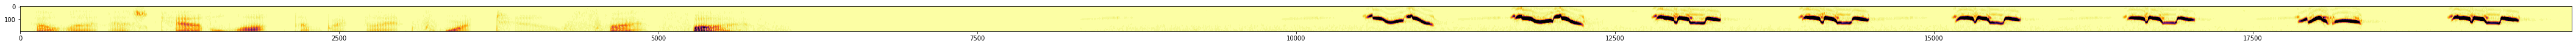

In [351]:
plt.figure(figsize=(75,150))
plt.imshow(sc0[:, :20000], cmap='inferno')
plt.show()

# HMM

In [365]:
def get_silent_pixels(silent_frames, start, end): # gets silent pixels in range [start,end]
    tmp = [frame_to_pixel(x) for x in silent_frames]
    tmp = [(int)(x) for x in tmp if x > start and x < end]
    return tmp

# s_pixels = get_silent_pixels(s_frames, 0, 20000)
s_pixels = get_silent_pixels(s_frames, 20000,40000)

In [367]:
s_pixels

[20005,
 20005,
 20006,
 20006,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20007,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20008,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20009,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20010,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20011,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,
 20012,


In [366]:
f = np.ones(20000)
f[[int(x) for x in s_pixels]] = 0
f ##################################### (0 == silent), (1 == heard)

IndexError: index 20005 is out of bounds for axis 0 with size 20000

In [312]:
f = np.array([[int(x)] for x in f])
f

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

## Note: (0 == silent), (1 == heard)

In [313]:
from hmmlearn import hmm

In [314]:
model = hmm.MultinomialHMM(n_components=2) # discrete multinomial HMM
model.fit(f)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=2,
               n_iter=10, params='ste',
               random_state=<mtrand.RandomState object at 0x7f308568cab0>,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
               verbose=False)

In [363]:
Z = model.predict(f)
Z

array([0, 0, 0, ..., 0, 0, 0])

In [335]:
model.startprob_

array([1.00000000e+00, 1.69030296e-15])

In [336]:
model.transmat_

array([[0.94937066, 0.05062934],
       [0.04109292, 0.95890708]])

In [358]:
model.transmat_ = np.array([[0.95,0.05],[0.01,0.99]])

In [337]:
model.emissionprob_

array([[0.97747512, 0.02252488],
       [0.18134517, 0.81865483]])

In [362]:
model.emissionprob_ = np.array([[0.6,0.4],[0.4,0.6]])

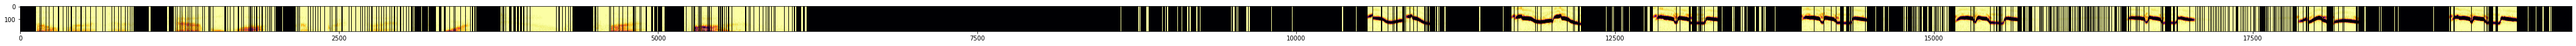

In [340]:
def test_preds(pixels, sc):
    end = len(pixels)
    
    hmm_sc = np.copy(sc)
    
    for i,p in enumerate(pixels):
        if not p: # if silent
            hmm_sc[:,i] = np.min(hmm_sc) * np.ones(hmm_sc.shape[0])
        
    plt.figure(figsize=(75,150))
    plt.imshow(hmm_sc[:, :end], cmap='inferno')
    plt.show()
    
    
test_preds(Z, sc0) # transmat = [[0.8,0.2],[0.2,0.8]]

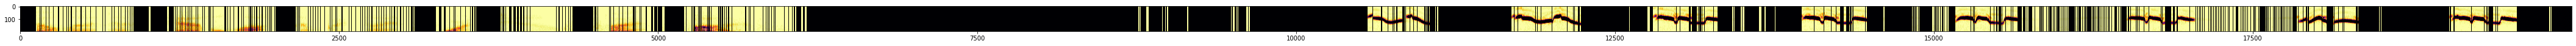

In [343]:
test_preds(Z, sc0) # transmat = [[0.90,0.1],[0.1,0.90]] emissionprob_ = np.array([[0.7,0.3],[0.3,0.7]])

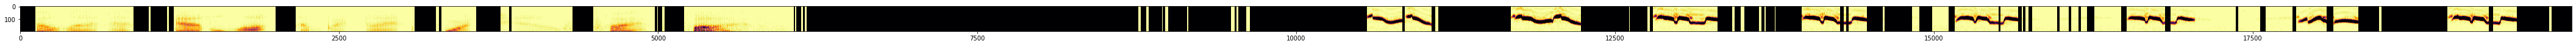

In [357]:
test_preds(Z, sc0) # transmat = [[0.95,0.05],[0.02,0.98]]

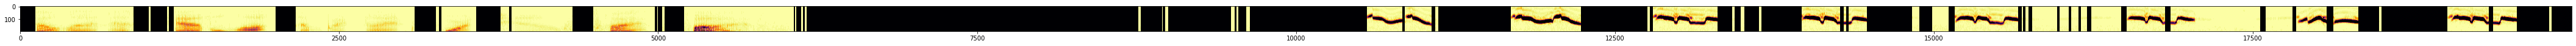

In [360]:
test_preds(Z, sc0) # transmat = [[0.95,0.05],[0.01,0.99]]

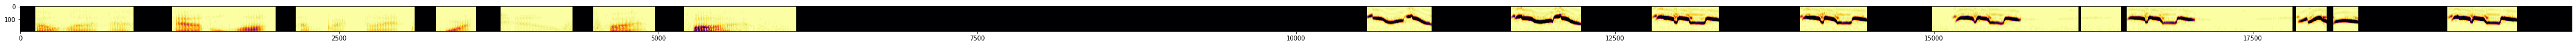

In [364]:
test_preds(Z, sc0) # emissionprob_ = np.array([[0.6,0.4],[0.4,0.6]])

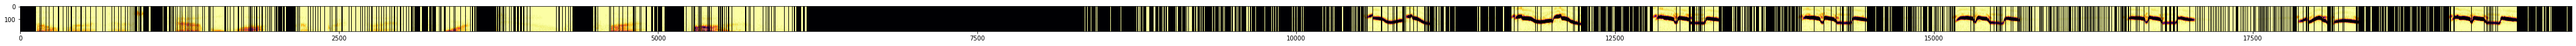

In [355]:
plt.figure(figsize=(75,150))
plt.imshow(sc0_frames[:, :20000], cmap='inferno') # SILENT FRAMES
plt.show()

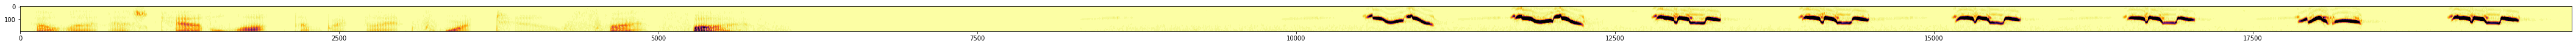

In [352]:
plt.figure(figsize=(75,150))
plt.imshow(sc0[:, :20000], cmap='inferno') # ORIGINAL SCALOGRAM
plt.show()

In [241]:
pixel_ranges

[[147, 154],
 [157, 164],
 [165, 172],
 [170, 176],
 [194, 201],
 [220, 227],
 [228, 235],
 [245, 252],
 [259, 266],
 [270, 277],
 [278, 285],
 [295, 302],
 [316, 323],
 [329, 336],
 [342, 348],
 [354, 361],
 [367, 374],
 [380, 386],
 [392, 399],
 [409, 416],
 [421, 428],
 [434, 441],
 [446, 453],
 [455, 462],
 [473, 480],
 [518, 525],
 [531, 538],
 [550, 557],
 [563, 569],
 [570, 576],
 [582, 589],
 [595, 602],
 [608, 615],
 [699, 706],
 [712, 719],
 [731, 738],
 [751, 758],
 [770, 777],
 [778, 784],
 [795, 802],
 [808, 815],
 [817, 824],
 [830, 837],
 [843, 849],
 [1010, 1017],
 [1154, 1161],
 [1216, 1223],
 [1220, 1226],
 [1235, 1242],
 [1247, 1254],
 [1287, 1293],
 [1301, 1308],
 [1312, 1319],
 [1320, 1327],
 [1324, 1330],
 [1338, 1345],
 [1343, 1349],
 [1354, 1360],
 [1360, 1367],
 [1364, 1371],
 [1369, 1376],
 [1391, 1398],
 [1393, 1400],
 [1407, 1414],
 [1421, 1427],
 [1435, 1442],
 [1505, 1512],
 [1517, 1523],
 [1533, 1540],
 [1545, 1552],
 [1580, 1587],
 [1605, 1612],
 [1614, 

In [242]:
def pixels_in_range(ranges, start, end):
    tmp = []
    for x,y in ranges:
        if x > start and y < end:
            tmp.append([x,y])
    return tmp

In [243]:
tmp = pixels_in_range(pixel_ranges, 12000, 14000)
tmp

[[12006, 12013],
 [12050, 12057],
 [12119, 12126],
 [12142, 12149],
 [12147, 12154],
 [12171, 12178],
 [12176, 12183],
 [12179, 12186],
 [12195, 12201],
 [12196, 12202],
 [12201, 12208],
 [12204, 12211],
 [12226, 12233],
 [12430, 12437],
 [12612, 12618],
 [12727, 12734],
 [12758, 12764],
 [12766, 12773],
 [12813, 12820],
 [12821, 12828],
 [12825, 12832],
 [12830, 12837],
 [12883, 12890],
 [12900, 12907],
 [12902, 12909],
 [12928, 12935],
 [12949, 12956],
 [12959, 12966],
 [12963, 12970],
 [12968, 12974],
 [12976, 12983],
 [13033, 13040],
 [13080, 13087],
 [13099, 13106],
 [13146, 13153],
 [13147, 13154],
 [13157, 13164],
 [13178, 13184],
 [13198, 13204],
 [13216, 13223],
 [13221, 13228],
 [13226, 13233],
 [13231, 13238],
 [13254, 13261],
 [13268, 13275],
 [13283, 13290],
 [13298, 13305],
 [13336, 13343],
 [13420, 13427],
 [13432, 13439],
 [13506, 13513],
 [13533, 13540],
 [13578, 13585],
 [13595, 13602],
 [13640, 13647],
 [13675, 13682],
 [13753, 13760],
 [13950, 13956],
 [13965, 13972

In [244]:
for x,y in tmp:
    sc0[:,x:y] = np.min(sc0) * np.ones((193,(y-x)))

In [354]:
tmp = [frame_to_pixel(x) for x in s_frames]

stmp = [(int)(x) for x in tmp if x > 0 and x < 20000]

sc0_silent = np.copy(sc0)
for x in np.array(list(set(stmp))):
    sc0_silent[:,x] = np.min(sc0_silent) * np.ones(193)

In [148]:
X = np.array(list(set(stmp)))

In [151]:
X = np.array(sorted(X))

In [154]:
tmp = [x-12001 for x in X]

In [161]:
tmp[:10]

[0, 2, 6, 12, 22, 55, 56, 81, 95, 114]

In [156]:
tmp[-1]

1985

In [169]:
sequence = np.array([[1]]*(tmp[-1]+1))
sequence[tmp] = [0]

In [170]:
sequence

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

[1, 1, 1]